# Détéction de Paiement Frauduleux

## Importer PySpark

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Fraud_Detection").getOrCreate()

24/07/01 15:08:09 WARN Utils: Your hostname, canette.local resolves to a loopback address: 127.0.0.1; using 192.168.0.15 instead (on interface en0)
24/07/01 15:08:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/01 15:08:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
#Utiliser spark pour extraire notre fichier
df = spark.read.csv('pay.csv', header=True) #Par default les titres des colonnes ne sont pas mit

In [5]:
df.printSchema() #Parcourir les données

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [6]:
#Vérificatin de la dimension
df_rows_size = df.count() #count() compte le nombre de ligne
df_col_size = len(df.columns)
print(df_rows_size, "x", df_col_size)

6362620 x 11


In [7]:
#Ajout d'une colonne id
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
window = Window.orderBy('nameOrig')
df_id = df.withColumn('id', row_number().over(window)-1)
df = df_id.select('id', *df.columns)

In [8]:
#suppressions des valeurs nulles
df.na.drop().show()

24/07/01 15:08:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| id|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+---+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|  0| 249|CASH_OUT| 244486.46|C1000000639|       8946.0|           0.0| C785826240|     526950.37|     771436.84|      0|             0|
|  1| 217| PAYMENT|   3170.28|C1000001337|      58089.0|      54918.72| M216466820|           0.0|           0.0|      0|             0|
|  2|  46| PAYMENT|   8424.74|C1000001725|        783.0|           0.0|M1974356374|           0.0|           0.0|      0|             0|
|  3| 231| CASH_IN| 261877.19|C1000002591|       7596.0|     269473.19| C503690069|     1126627.7|     864750.51|      0|             0|
|  4| 167| CASH_IN|  20528.65|C1000003372

In [9]:
#Suppresion des lignes en double
df = df.dropDuplicates()

In [10]:
#Transformation des noms de colonnes en minuscule
from pyspark.sql.functions import col
old_cols =df.columns
new_cols = [col(col_name).alias(col_name.lower()) for col_name in old_cols]

In [11]:
#On reselectionne toute les colonnes
df = df.select(*new_cols)

In [12]:
#On vérifie si tout est bon
df.columns

['id',
 'step',
 'type',
 'amount',
 'nameorig',
 'oldbalanceorg',
 'newbalanceorig',
 'namedest',
 'oldbalancedest',
 'newbalancedest',
 'isfraud',
 'isflaggedfraud']

In [13]:
df.show()

24/07/01 15:08:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:08:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/07/01 15:08:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/07/01 15:08:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but

+---+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| id|step|    type|    amount|   nameorig|oldbalanceorg|newbalanceorig|   namedest|oldbalancedest|newbalancedest|isfraud|isflaggedfraud|
+---+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|  0| 249|CASH_OUT| 244486.46|C1000000639|       8946.0|           0.0| C785826240|     526950.37|     771436.84|      0|             0|
|  1| 217| PAYMENT|   3170.28|C1000001337|      58089.0|      54918.72| M216466820|           0.0|           0.0|      0|             0|
|  2|  46| PAYMENT|   8424.74|C1000001725|        783.0|           0.0|M1974356374|           0.0|           0.0|      0|             0|
|  3| 231| CASH_IN| 261877.19|C1000002591|       7596.0|     269473.19| C503690069|     1126627.7|     864750.51|      0|             0|
|  4| 167| CASH_IN|  20528.65|C1000003372

In [14]:
df.printSchema()

root
 |-- id: integer (nullable = false)
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameorig: string (nullable = true)
 |-- oldbalanceorg: string (nullable = true)
 |-- newbalanceorig: string (nullable = true)
 |-- namedest: string (nullable = true)
 |-- oldbalancedest: string (nullable = true)
 |-- newbalancedest: string (nullable = true)
 |-- isfraud: string (nullable = true)
 |-- isflaggedfraud: string (nullable = true)



In [15]:
# Convert features to numericals to be usable
cols_to_convert = ["amount","oldbalanceorg","newbalanceorig", "oldbalancedest", "newbalancedest","isfraud", "isflaggedfraud"]

for c in cols_to_convert:
    if(c=='isfraud' or c=='isflaggedfraud'):
        df = df.withColumn(c, col(c).cast('int'))
    else:
        df = df.withColumn(c, col(c).cast("float"))


In [16]:
#Check if all is okey
df.printSchema()

root
 |-- id: integer (nullable = false)
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameorig: string (nullable = true)
 |-- oldbalanceorg: float (nullable = true)
 |-- newbalanceorig: float (nullable = true)
 |-- namedest: string (nullable = true)
 |-- oldbalancedest: float (nullable = true)
 |-- newbalancedest: float (nullable = true)
 |-- isfraud: integer (nullable = true)
 |-- isflaggedfraud: integer (nullable = true)



# 2.Exploration and data analysis

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import rand

In [18]:
df_pd = df.sample(False, 0.001, seed=42).toPandas()
# why 0.001 ? : My computer doesnt doesnt support seaborn with more than 10k sample ^^ 

24/07/01 15:09:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:09:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:09:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/01 15:09:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/07/01 15:09:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/07/01 15:09:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but

In [19]:
print(f"La taille du sample df : {df_pd.shape}")

La taille du sample df : (6256, 12)


In [20]:
df_pd.head()

,id,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
0,7295,43,CASH_IN,28867.640625,C1002200628,7.130000e+03,3.599764e+04,C623794592,3.581136e+06,3.552268e+06,0,0
1,7408,138,CASH_IN,203533.031250,C1002235725,1.602329e+06,1.805862e+06,C1959834166,5.413796e+05,3.378466e+05,0,0
2,7634,275,CASH_OUT,43794.871094,C1002302110,0.000000e+00,0.000000e+00,C638243290,1.612454e+06,1.656249e+06,0,0
3,8299,20,DEBIT,4534.720215,C1002495916,0.000000e+00,0.000000e+00,C1016178591,8.932028e+04,9.385500e+04,0,0
4,9180,36,PAYMENT,14926.509766,C100275036,6.915808e+05,6.766543e+05,M916821507,0.000000e+00,0.000000e+00,0,0


## The following plots arent representative of the whole dataframe :


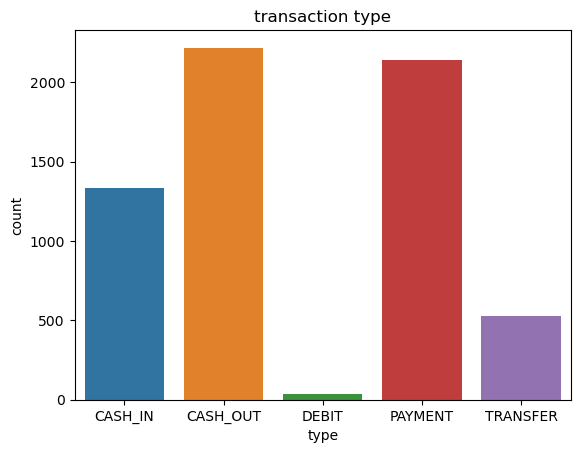

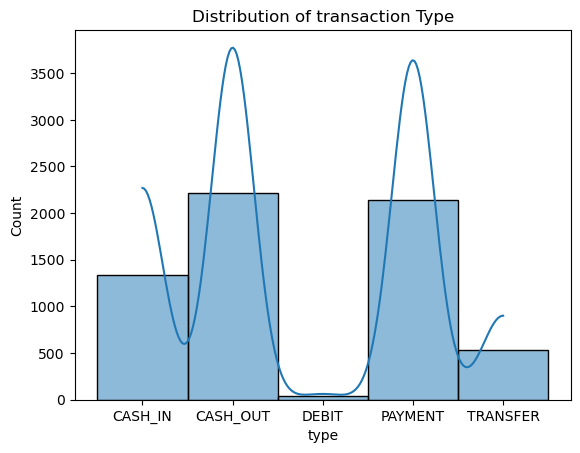

In [21]:
#Transaction type
sns.countplot(x='type', data = df_pd)
plt.title('transaction type')
plt.show()

sns.histplot(data=df_pd, x='type', kde=True)
plt.title('Distribution of transaction Type')
plt.show()

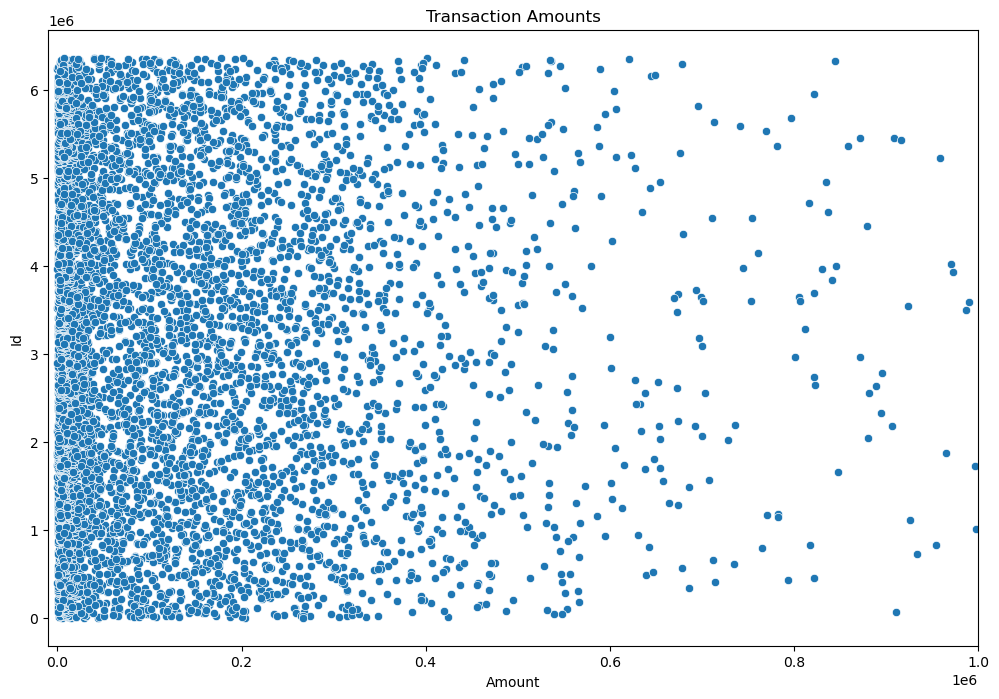

In [22]:
# Transaction amount 
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_pd, x='amount', y='id')
plt.title('Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Id')
plt.xlim(-1e4, 1e6)
plt.show()

In [23]:
correlation_matrix = df_pd[['amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest', 'newbalancedest']].corr()
correlation_matrix

,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest
amount,1.000000,0.001825,-0.007704,0.219205,0.381414
oldbalanceorg,0.001825,1.000000,0.998465,0.069857,0.046045
newbalanceorig,-0.007704,0.998465,1.000000,0.072701,0.045629
oldbalancedest,0.219205,0.069857,0.072701,1.000000,0.982580
newbalancedest,0.381414,0.046045,0.045629,0.982580,1.000000


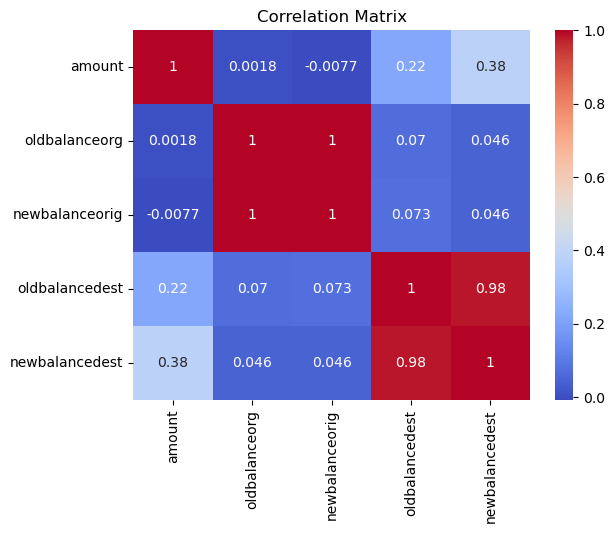

In [24]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

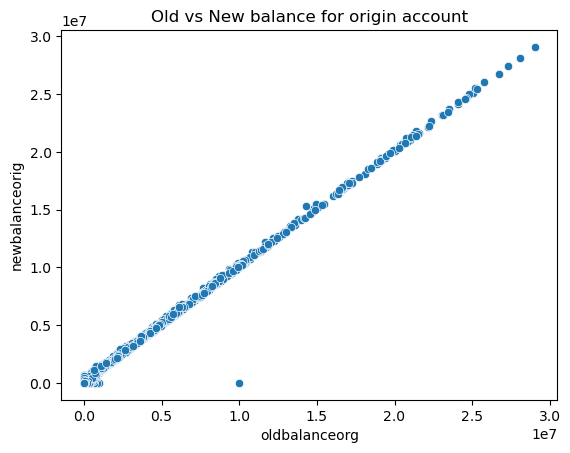

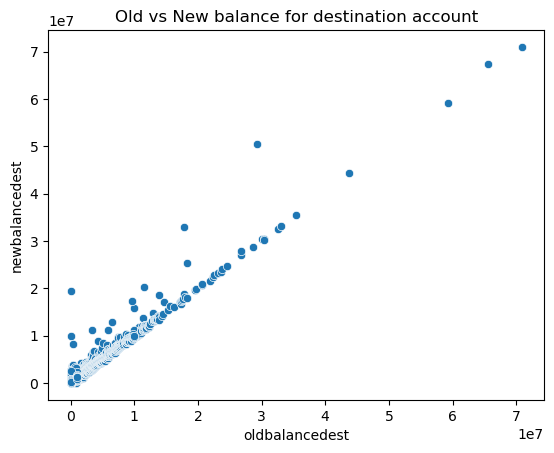

In [25]:
# Compare balance before and after transaction

# origin
sns.scatterplot(x='oldbalanceorg', y='newbalanceorig', data=df_pd)
plt.title('Old vs New balance for origin account')
plt.show()

# dest
sns.scatterplot(x='oldbalancedest', y='newbalancedest', data=df_pd)
plt.title('Old vs New balance for destination account')
plt.show()

## 3. Detect the fraud

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [27]:
# Split the DataFrame into features (X) and target (y) 

numeric_features = ['amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest', 'newbalancedest']

X = df_pd[numeric_features]
y = df_pd['isfraud']

# Split the DataFrame into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [28]:
rf = RandomForestClassifier()


In [29]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
y_pred = rf.predict(X_test)


In [31]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy}")

Accuracy : 1.0


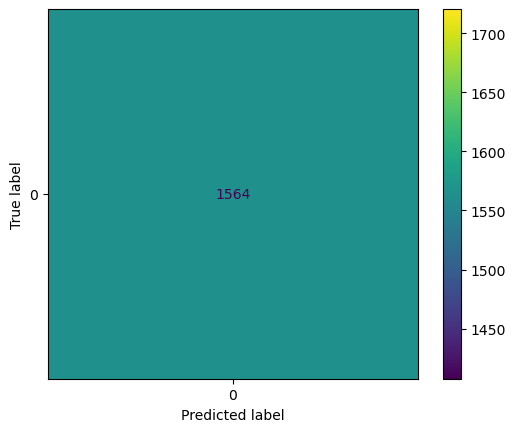

In [33]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()